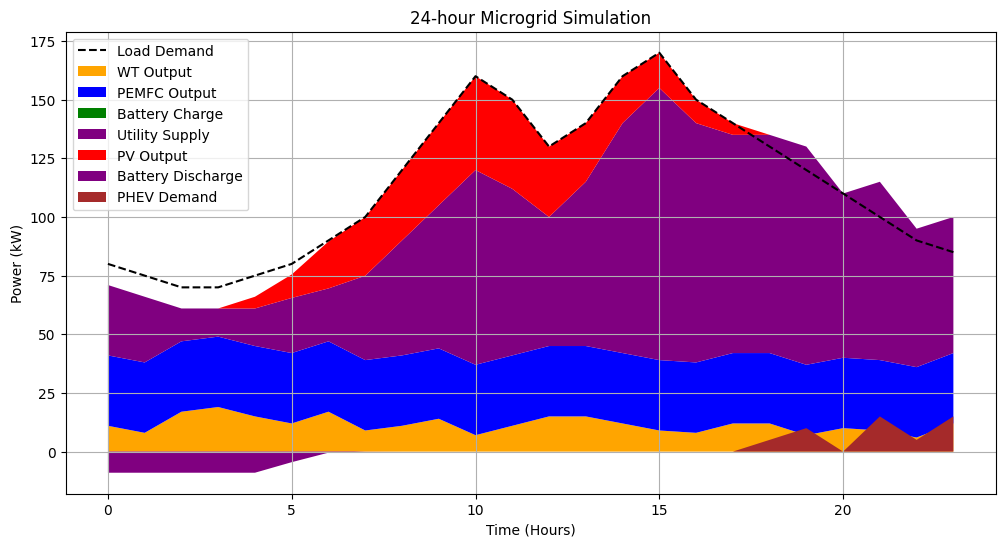

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 24時間のシミュレーション
hours = np.arange(24)

# 需要電力（kW）
load_demand = np.array([80, 75, 70, 70, 75, 80, 90, 100, 120, 140, 160, 150,
                        130, 140, 160, 170, 150, 140, 130, 120, 110, 100, 90, 85])

# 太陽光発電（PV）出力（kW）
pv_output = np.array([0, 0, 0, 0, 5, 10, 20, 25, 30, 35, 40, 38,
                      30, 25, 20, 15, 10, 5, 0, 0, 0, 0, 0, 0])

# 風力発電（WT）出力（kW, ランダム）
np.random.seed(42)
wt_output = np.random.randint(5, 20, size=24)

# 燃料電池（PEMFC-CHP）出力（kW）
pemfc_output = np.full(24, 30)  # 一定出力

# 蓄電池（Battery）設定
battery_capacity = 100  # 最大容量（kWh）
battery_soc = 50  # 初期SOC（50%）
battery_charge_rate = 10  # 最大充電・放電能力（kW）
battery_efficiency = 0.9  # 充放電効率

battery_output = np.zeros(24)  # 充放電履歴

# PHEV充電（18:00-24:00の間にランダムに充電開始）
phev_demand = np.zeros(24)
for i in range(10):  # 10台のPHEV
    start_time = np.random.randint(18, 24)
    phev_demand[start_time] += 5  # 1台あたり5kWの充電負荷

# グリッドからの供給電力（Utility）
utility_output = np.zeros(24)

# シミュレーション開始
for t in range(24):
    # 総発電量
    total_generation = pv_output[t] + wt_output[t] + pemfc_output[t]
    
    # 総需要（負荷 + PHEV充電）
    total_demand = load_demand[t] + phev_demand[t]
    
    # 電力不足分を蓄電池で補う
    power_shortage = total_demand - total_generation
    if power_shortage > 0:
        discharge = min(power_shortage, battery_charge_rate, battery_soc) * battery_efficiency
        battery_output[t] = -discharge  # 放電
        battery_soc -= discharge
        power_shortage -= discharge
    
    # それでも足りない場合はグリッドから購入
    if power_shortage > 0:
        utility_output[t] = power_shortage
    
    # 余剰電力がある場合は蓄電
    power_surplus = total_generation - total_demand
    if power_surplus > 0:
        charge = min(power_surplus, battery_charge_rate, battery_capacity - battery_soc) * battery_efficiency
        battery_output[t] = charge  # 充電
        battery_soc += charge

# 結果を可視化
plt.figure(figsize=(12, 6))
plt.plot(hours, load_demand, label="Load Demand", linestyle="--", color="black")
# 下のグラフは積み上げ棒グラフ
# バッテリー出力を正負で分離
battery_charge = np.where(battery_output > 0, battery_output, 0)
battery_discharge = np.where(battery_output < 0, battery_output, 0)

# 積み上げ棒グラフの作成
plt.stackplot(hours, 
             wt_output, 
             pemfc_output,
             battery_charge,
             utility_output,
             pv_output,
             labels=["WT Output", "PEMFC Output", "Battery Charge", "Utility Supply", "PV Output"],
             colors=["orange", "blue", "green", "purple", "red"])

# バッテリー放電は負の値なので別途プロット
plt.stackplot(hours,
             battery_discharge,
             labels=["Battery Discharge"],
             colors=["purple"])

# PHEV需要は別途プロット
plt.stackplot(hours,
             phev_demand,
             labels=["PHEV Demand"],
             colors=["brown"])

plt.xlabel("Time (Hours)")
plt.ylabel("Power (kW)")
plt.title("24-hour Microgrid Simulation")
plt.legend()
plt.grid()
plt.show()